In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

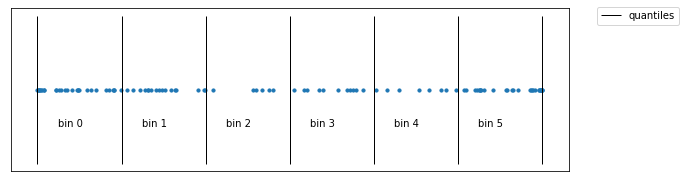

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
points = np.random.beta(.5, .5, size=100)
plt.scatter(points, np.zeros(100), s=10)
bin_edges = np.linspace(points.min(), points.max(), 7)
plt.vlines(bin_edges, ymin=-.1, ymax=.1, lw=1, label='quantiles')
plt.xticks(())
plt.yticks(())
plt.legend(loc=(1.05, .9))
for i, (q1, q2) in enumerate(zip(bin_edges, bin_edges[1:])):
    #plt.text((q1 + q2)/2, -.05, f"bin {i}")
    plt.text(q1 + 0.04, -.05, f"bin {i}")

plt.savefig("images/binning.png")

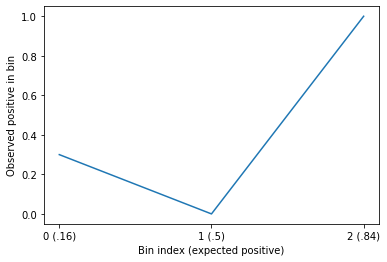

In [3]:
# toy plot
plt.plot([.3, 0, 1])
plt.xticks((0, 1, 2), ("0 (.16)", "1 (.5)", "2 (.84)"))
plt.xlabel("Bin index (expected positive)")
plt.ylabel("Observed positive in bin")
plt.savefig("images/calib_curve.png")

In [4]:
from sklearn.datasets import fetch_covtype
from sklearn.utils import check_array

def load_data(dtype=np.float32, order='C', random_state=13):
    ######################################################################
    # Load covertype dataset (downloads it from the web, might take a bit)
    data = fetch_covtype(download_if_missing=True, shuffle=True,
                         random_state=random_state)
    X = check_array(data['data'], dtype=dtype, order=order)
    # make it bineary classification
    y = (data['target'] != 1).astype(np.int)

    # Create train-test split (as [Joachims, 2006])
    n_train = 522911
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    # Standardize first 10 features (the numerical ones)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    mean[10:] = 0.0
    std[10:] = 1.0
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

# subsample training set by a factor of 10:
X_train = X_train[::10]
y_train = y_train[::10]

/home/andy/checkout/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
from sklearn.linear_model import LogisticRegressionCV
print(X_train.shape)
print(np.bincount(y_train))
lr = LogisticRegressionCV().fit(X_train, y_train)

(52292, 54)
[19036 33256]


/home/andy/checkout/scikit-learn/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/andy/checkout/scikit-learn/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warn

In [6]:
lr.C_

array([21.544])

In [7]:
print(lr.predict_proba(X_test)[:10])
print(y_test[:10])

[[0.681 0.319]
 [0.049 0.951]
 [0.706 0.294]
 [0.537 0.463]
 [0.819 0.181]
 [0.    1.   ]
 [0.794 0.206]
 [0.676 0.324]
 [0.727 0.273]
 [0.597 0.403]]
[0 1 0 1 1 1 0 0 0 1]


In [8]:
from sklearn.calibration import calibration_curve
probs = lr.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(prob_true)
print(prob_pred)

[0.199 0.304 0.458 0.71  0.933]
[0.138 0.306 0.498 0.701 0.926]


Text(0.5, 1.0, 'n_bins=5')

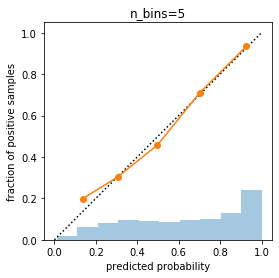

In [9]:
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

    
plot_calibration_curve(y_test, probs)
plt.title("n_bins=5")

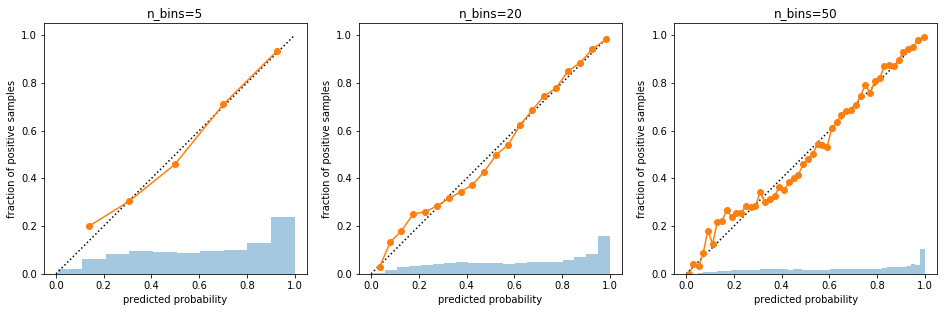

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
for ax, n_bins in zip(axes, [5, 20, 50]):
    plot_calibration_curve(y_test, probs, n_bins=n_bins, ax=ax)
    ax.set_title("n_bins={}".format(n_bins))
plt.savefig("images/influence_bins.png")

/home/andy/checkout/scikit-learn/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/andy/checkout/scikit-learn/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warn

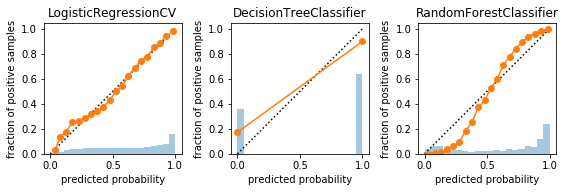

In [11]:
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
fig, axes = plt.subplots(1, 3, figsize=(8, 8))
for ax, clf in zip(axes, [LogisticRegressionCV(), DecisionTreeClassifier(),
                          RandomForestClassifier()]):
        # use predict_proba is the estimator has it
        scores = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        plot_calibration_curve(y_test, scores, n_bins=20, ax=ax)
        ax.set_title(clf.__class__.__name__)

plt.tight_layout()
plt.savefig("images/calib_curve_models.png")

/home/andy/checkout/scikit-learn/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/andy/checkout/scikit-learn/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warn

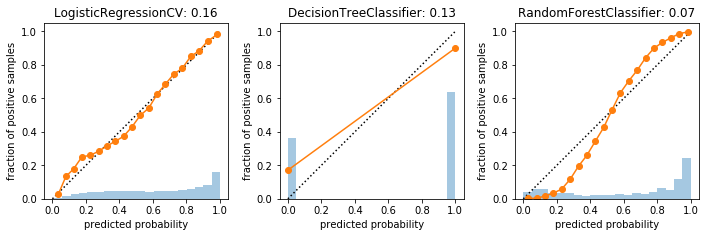

In [12]:
# same thing but with bier loss shown. Why do I refit the models? lol
from sklearn.metrics import brier_score_loss
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for ax, clf in zip(axes, [LogisticRegressionCV(), DecisionTreeClassifier(), RandomForestClassifier()]):
        # use predict_proba is the estimator has it
        scores = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        plot_calibration_curve(y_test, scores, n_bins=20, ax=ax)
        ax.set_title("{}: {:.2f}".format(clf.__class__.__name__, brier_score_loss(y_test, scores)))

plt.tight_layout()
plt.savefig("images/models_bscore.png")

In [13]:
from sklearn.calibration import CalibratedClassifierCV
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          stratify=y_train, random_state=0)

In [14]:
rf = RandomForestClassifier().fit(X_train_sub, y_train_sub)
scores = rf.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'RandomForestClassifier: 0.077')

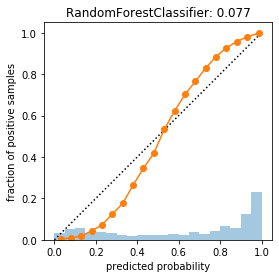

In [15]:
plot_calibration_curve(y_test, scores, n_bins=20)
plt.title("{}: {:.3f}".format(clf.__class__.__name__, brier_score_loss(y_test, scores)))

In [16]:
cal_rf = CalibratedClassifierCV(rf, cv="prefit", method='sigmoid')
cal_rf.fit(X_val, y_val)
scores_sigm = cal_rf.predict_proba(X_test)[:, 1]

cal_rf_iso = CalibratedClassifierCV(rf, cv="prefit", method='isotonic')
cal_rf_iso.fit(X_val, y_val)
scores_iso = cal_rf_iso.predict_proba(X_test)[:, 1]

In [17]:
scores_rf = cal_rf.predict_proba(X_val)

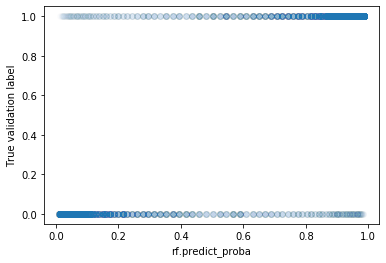

In [18]:
plt.plot(scores_rf[:, 1], y_val, 'o', alpha=.01)
plt.xlabel("rf.predict_proba")
plt.ylabel("True validation label")
plt.savefig("images/calibration_val_scores.png")

In [19]:
sigm = cal_rf.calibrated_classifiers_[0].calibrators_[0]
scores_rf_sorted = np.sort(scores_rf[:, 1])
sigm_scores = sigm.predict(scores_rf_sorted)

In [20]:
iso = cal_rf_iso.calibrated_classifiers_[0].calibrators_[0]
iso_scores = iso.predict(scores_rf_sorted)

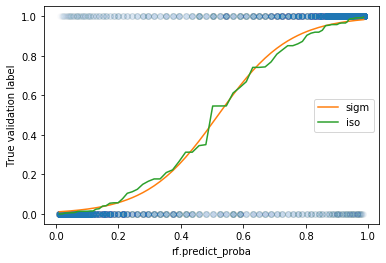

In [21]:
plt.plot(scores_rf[:, 1], y_val, 'o', alpha=.01)
plt.plot(scores_rf_sorted, sigm_scores, label='sigm')
plt.plot(scores_rf_sorted, iso_scores, label='iso')

plt.xlabel("rf.predict_proba")
plt.ylabel("True validation label")
plt.legend()
plt.savefig("images/calibration_val_scores_fitted.png")

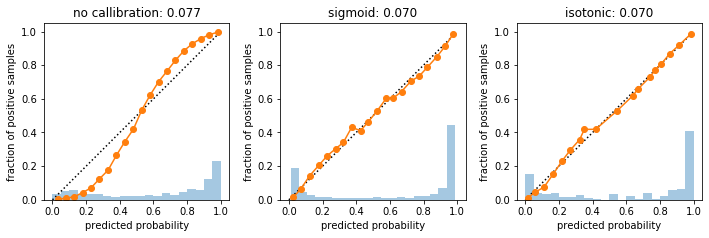

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for name, s, ax in zip(['no callibration', 'sigmoid', 'isotonic'],
                       [scores, scores_sigm, scores_iso], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()
plt.savefig("images/types_callib.png")

In [23]:
cal_rf_iso_cv = CalibratedClassifierCV(rf, method='isotonic')
cal_rf_iso_cv.fit(X_train, y_train)
scores_iso_cv = cal_rf_iso_cv.predict_proba(X_test)[:, 1]

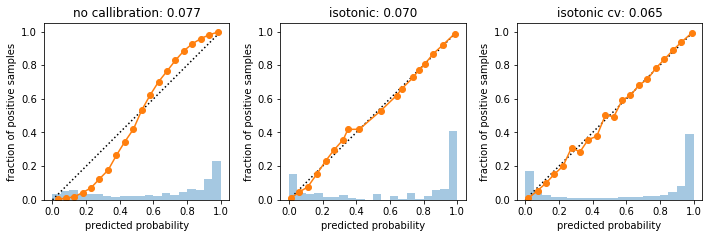

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for name, s, ax in zip(['no callibration', 'isotonic', 'isotonic cv'],
                       [scores, scores_iso, scores_iso_cv], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()
plt.savefig("images/types_callib_cv.png")

Log-loss of
 * uncalibrated classifier trained on 800 datapoints: 1.280 
 * classifier trained on 600 datapoints and calibrated on 200 datapoint: 0.534


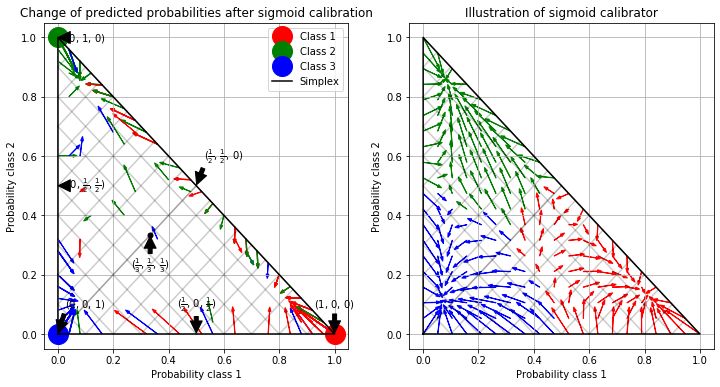

In [25]:
# http://scikit-learn.org/dev/auto_examples/calibration/plot_calibration_multiclass.html

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.


import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, brier_score_loss

np.random.seed(0)

# Generate data
X, y = make_blobs(n_samples=1000, n_features=2, random_state=42,
                  cluster_std=5.0)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:800], y[600:800]
X_train_valid, y_train_valid = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
#score = brier_score_loss(y_test, clf_probs[:, 1])

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)
#sig_score = brier_score_loss(y_test, sig_clf_probs[:, 1])

# Plot changes in predicted probabilities via arrows
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
colors = ["r", "g", "b"]
for i in range(clf_probs.shape[0]):
    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
              sig_clf_probs[i, 0] - clf_probs[i, 0],
              sig_clf_probs[i, 1] - clf_probs[i, 1],
              color=colors[y_test[i]], head_width=1e-2)

# Plot perfect predictions
plt.plot([1.0], [0.0], 'ro', ms=20, label="Class 1")
plt.plot([0.0], [1.0], 'go', ms=20, label="Class 2")
plt.plot([0.0], [0.0], 'bo', ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

# Annotate points on the simplex
plt.annotate(r'($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)',
             xy=(1.0/3, 1.0/3), xytext=(1.0/3, .23), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.plot([1.0/3], [1.0/3], 'ko', ms=5)
plt.annotate(r'($\frac{1}{2}$, $0$, $\frac{1}{2}$)',
             xy=(.5, .0), xytext=(.5, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $\frac{1}{2}$, $\frac{1}{2}$)',
             xy=(.0, .5), xytext=(.1, .5), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($\frac{1}{2}$, $\frac{1}{2}$, $0$)',
             xy=(.5, .5), xytext=(.6, .6), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $0$, $1$)',
             xy=(0, 0), xytext=(.1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($1$, $0$, $0$)',
             xy=(1, 0), xytext=(1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $1$, $0$)',
             xy=(0, 1), xytext=(.1, 1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
# Add grid
plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Change of predicted probabilities after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.legend(loc="best")

print("Log-loss of")
print(" * uncalibrated classifier trained on 800 datapoints: %.3f "
      % score)
print(" * classifier trained on 600 datapoints and calibrated on "
      "200 datapoint: %.3f" % sig_score)

# Illustrate calibrator
plt.subplot(1, 2, 2)
# generate grid over 2-simplex
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

calibrated_classifier = sig_clf.calibrated_classifiers_[0]
prediction = np.vstack([calibrator.predict(this_p)
                        for calibrator, this_p in
                        zip(calibrated_classifier.calibrators_, p.T)]).T
prediction /= prediction.sum(axis=1)[:, None]

# Plot modifications of calibrator
for i in range(prediction.shape[0]):
    plt.arrow(p[i, 0], p[i, 1],
              prediction[i, 0] - p[i, 0], prediction[i, 1] - p[i, 1],
              head_width=1e-2, color=colors[np.argmax(p[i])])
# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Illustration of sigmoid calibrator")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.savefig("images/multi_class_calibration.png")